In [17]:
import numpy as np
import sklearn
import os
import random
import math
import pickle

from tqdm import tqdm
from scipy.io import loadmat

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

np.random.seed(1)



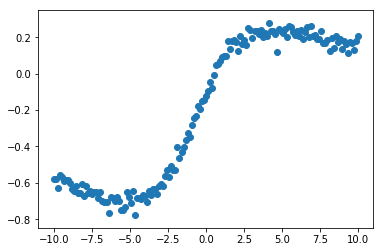

In [18]:
loaded_data = pickle.load(open("adaptive_data2.pickle", 'rb'))
X = loaded_data["X"]
Y = loaded_data["Y"]

plt.scatter(loaded_data["X"][:, 1], loaded_data["Y"])
plt.show()

In [19]:
data = np.concatenate([X, Y.reshape((151, 1))], axis=1)
np.random.shuffle(data)

train  = data[:50, :]
validation = data[50:100, :]
test = data[100:150, :]


X_train = train[:, 0:2]
Y_train = train[:, 2]

X_valid = validation[:, 0:2]
Y_valid = validation[:, 2]


X_test  = test[:, 0:2]
Y_test  = test[:, 2]



In [20]:
# Data = {
#     "X_train" : X_train,
#     "Y_train" : Y_train,
#     "X_valid" : X_valid,
#     "Y_valid" : Y_valid,
#     "X_test"  : X_test,
#     "Y_test"  : Y_test
# }

# pickle.dump(Data, open("Data/Data2.pickle", 'wb'))


# Hyperparameters

In [5]:
Sigma_u = math.pow(10, 0.2)*np.identity(2)
C_term  = 1
Noise_variance = 1e-3

# Gaussian Process fit and predict

In [6]:
def Kernel(x1, x2):  # K_input part of ICM kernel
    numerator    = 2*np.dot(np.dot(x1, Sigma_u), x2 )
    denominator1 = 1 + 2*np.dot(np.dot(x1, Sigma_u), x1 )
    denominator2 = 1 + 2*np.dot(np.dot(x2, Sigma_u), x2 )
    denominator  = math.sqrt(denominator1*denominator2) # See "Computing with infinite networks" for calculation of Expectation term 
    
    Expectation_term = (2/np.pi) * math.asin( numerator/denominator )
    similarity       = C_term +  Expectation_term  # See "Multitask Neural networks meet Multitask Gaussian Process" Paper for notation of C-term and Expectation term
    return similarity 




def mtgp_fit (X_train, Y_train, Noise_variance ): 
    N = len(X_train)
    K = np.zeros((N, N))
            
    for i in range(0, N):
        for j in range(0, N):
            K[i, j] = Kernel(X_train[i],  X_train[j] )
            
    B = np.zeros((N, N))
    for i in range(0, N):
        B[i, i] = Noise_variance
         
    
    C = K + B
    C_inv = np.linalg.inv(C)
    alpha = np.dot(C_inv, Y_train)
    model = {
        "X_train" :  X_train,
        "Y_train" :  Y_train,
        "Noise_variance" : Noise_variance,
        "C_inv"   :  C_inv,
        "alpha"   :  alpha,
    }
    
    return model



def mtgp_predict(X,  model):
    
    n_train  = len(model["X_train"])
    n        = len(X)
    K        = np.zeros((n_train, n))
    
    for i in range(0, n_train):
        for j in range(0, n):
            K[i, j] = Kernel( model["X_train"][i],  X[j] )
            
    y_pred = np.dot(K.T, model["alpha"] )
    return y_pred




def get_stats (y_true, y_predict):
    msr = mean_squared_error(y_true, y_predict)
    stats ={
        "msr" : msr
    }
    
    return stats



In [7]:
model = mtgp_fit (X_train, Y_train, Noise_variance )
predict = mtgp_predict(X_valid,  model)
stats = get_stats(Y_valid, predict)
print("Validation Loss with True Hyperparameters :", stats['msr'])

Validation Loss with True Hyperparameters : 0.0014354642359464445


In [8]:
def get_Negative_Loss (
    Sigma_u_temp, noise_variance_temp
):
    global Sigma_u
    global Noise_variance
    
    Sigma_u = math.pow(10, Sigma_u_temp)*np.identity(2)
    Noise_variance = math.pow(10, noise_variance_temp)
    
    model = mtgp_fit (X_train, Y_train, Noise_variance )
    predict = mtgp_predict(X_valid,  model)
    stats = get_stats(Y_valid, predict)
    return -stats['msr']


In [9]:
from bayes_opt import BayesianOptimization


pbounds = {
            "Sigma_u_temp" : (-4, 2),
            "noise_variance_temp" : (-6, 0),
          }



optimizer = BayesianOptimization(
    f= get_Negative_Loss,
    pbounds=pbounds,
    random_state=1,
)


In [10]:
optimizer.maximize(
    init_points=200,
    n_iter=100,
)

|   iter    |  target   | Sigma_... | noise_... |
-------------------------------------------------
|  1        | -0.03031  | -1.498    | -1.678    |
|  2        | -0.05096  | -3.999    | -4.186    |
|  3        | -0.05294  | -3.119    | -5.446    |
|  4        | -0.04885  | -2.882    | -3.927    |
|  5        | -0.01338  | -1.619    | -2.767    |
|  6        | -0.02493  | -1.485    | -1.889    |
|  7        | -0.05053  | -2.773    | -0.7313   |
|  8        | -0.05096  | -3.836    | -1.977    |
|  9        | -0.01052  | -1.496    | -2.648    |
|  10       | -0.05032  | -3.158    | -4.811    |
|  11       | -0.0143   |  0.8045   | -0.1904   |
|  12       | -0.04361  | -2.119    | -1.846    |
|  13       | -0.005931 |  1.258    | -0.6324   |
|  14       | -0.05072  | -3.49     | -5.766    |
|  15       | -0.05048  | -2.981    | -0.7311   |
|  16       | -0.04891  | -3.41     | -3.473    |
|  17       | -0.001535 |  1.747    | -2.801    |
|  18       | -0.001557 |  0.1513   | -4.107    |


|  100      | -0.02257  | -0.2993   | -0.3059   |
|  101      | -0.001505 |  1.701    | -2.66     |
|  102      | -0.001397 |  1.494    | -2.151    |
|  103      | -0.01173  | -1.66     | -3.084    |
|  104      | -0.001389 | -0.3741   | -2.703    |
|  105      | -0.007225 |  1.557    | -0.4876   |
|  106      | -0.04725  | -1.631    | -0.2204   |
|  107      | -0.05182  | -2.956    | -5.242    |
|  108      | -0.04844  | -3.19     | -2.966    |
|  109      | -0.04881  | -3.871    | -0.3122   |
|  110      | -0.01002  |  0.9627   | -5.91     |
|  111      | -0.04844  | -2.943    | -4.008    |
|  112      | -0.05073  | -3.214    | -1.143    |
|  113      | -0.04844  | -1.932    | -0.3594   |
|  114      | -0.01765  | -0.5079   | -0.727    |
|  115      | -0.007143 |  1.068    | -0.5676   |
|  116      | -0.004934 | -1.241    | -2.722    |
|  117      | -0.001672 |  0.7916   | -4.286    |
|  118      | -0.003861 | -1.058    | -2.405    |
|  119      | -0.05112  | -3.907    | -2.439    |


|  201      | -0.01492  |  1.994    | -0.01416  |
|  202      | -0.002416 |  2.0      | -6.0      |
|  203      | -0.001844 |  1.998    | -3.603    |
|  204      | -0.002375 |  1.994    | -5.528    |
|  205      | -0.001962 |  0.06406  | -5.992    |
|  206      | -0.001815 | -1.287    | -5.998    |
|  207      | -0.002081 | -1.077    | -3.801    |
|  208      | -0.002081 |  2.0      | -4.243    |
|  209      | -0.001706 | -0.1409   | -5.59     |
|  210      | -0.001746 | -1.01     | -4.5      |
|  211      | -0.001611 |  1.507    | -3.312    |
|  212      | -0.001902 |  0.7836   | -5.1      |
|  213      | -0.001733 |  1.561    | -1.315    |
|  214      | -0.001667 |  0.01419  | -1.79     |
|  215      | -0.001653 |  1.997    | -3.136    |
|  216      | -0.00144  |  1.998    | -2.241    |
|  217      | -0.002669 | -1.131    | -3.361    |
|  218      | -0.002101 |  1.998    | -1.13     |
|  219      | -0.001431 |  0.5641   | -2.761    |
|  220      | -0.0018   | -1.128    | -5.01     |


In [11]:
print(optimizer.max)

{'target': -0.001347685740480363, 'params': {'Sigma_u_temp': -0.01935101308931131, 'noise_variance_temp': -2.2698256787452693}}


Notes:

Data1: 

True Parameters = ('Sigma_u_temp': 0.2, noise_variance_temp'-3 }
True Parameters = ('Sigma_u_temp':  -0.01935101308931131, noise_variance_temp': -2.2698256787452693 }

Validation Loss with True Hyperparameters : 0.0014354642359464445
Validation Loss with BO Hyperparameters : 0.001347685740480363

Test Loss with True Hyperparameters :  0.012566240611562893
Test Loss with BO Hyperparameters :  0.0013801670304919448

======================================================================

Data2:

True Parameters = ('Sigma_u_temp': -1.5, noise_variance_temp': -3 }
BO Parameters = ('Sigma_u_temp': -1.0362543143120915, noise_variance_temp': -2.0003612439206298 }

Test Loss with True Hyperparameters :  0.0008560375892366575
Test Loss with BO Hyperparameters :    0.000963638135689729

Valid Loss with True Hyperparameters :  0.0012524983745783797
Valid Loss with BO Hyperparameters :  0.0011319722106009854


In [12]:
Sigma_u = math.pow(10, -1.5)*np.identity(2)
C_term  = 1
Noise_variance = 1e-3



model = mtgp_fit (X_train, Y_train, Noise_variance )
predict = mtgp_predict(X_test,  model)
stats = get_stats(Y_test, predict)
print("Test Loss with True Hyperparameters : ", stats['msr'])



Sigma_u = math.pow(10, optimizer.max['params']["Sigma_u_temp"] )*np.identity(2)
C_term  = 1
Noise_variance = math.pow(10, optimizer.max['params']["noise_variance_temp"]  )


model = mtgp_fit (X_train, Y_train, Noise_variance )
predict = mtgp_predict(X_test,  model)
stats = get_stats(Y_test, predict)
print("Test Loss with BO Hyperparameters : ", stats['msr'])

Test Loss with True Hyperparameters :  0.012566240611562893
Test Loss with BO Hyperparameters :  0.0013801670304919448
